# Trabalho prático - Visão por Computador e Processamento de Imagem

#### Autores: Cláudio Moreira (PG47844), Filipe Fernandes(------)

## Aplicação de tranformações

Para o presente trabalho foi proposta a exploração de modelos de *Deep Learning*. Numa primeira parte, é suposto treinar modelos aplicando *data augmentation*, tanto em pré-processamento como dinâmico.

Neste *notebook* explorou-se a possibilidade de alterações em relação à formatação das imagens. Para isso, foram utilizadas as funções auxiliares (*process_image_trans* e *process_image_rot*) fornecidas pelo doncente da unidade curricular. Estas realizam transformações de tranlações e rotações respetivamente. Sendo assim, começamos por realizar os imports necessários para a o desenvolvimento do projeto.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

import os
import numpy as np
# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [4]:
#GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avasilable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Avasilable:  0


IndexError: list index out of range

### Função auxiliar utilizada para mostrar um batch

In [5]:
def show_batch(image_batch, label_batch, epoch):
  columns = 5
  rows = BATCH_SIZE / columns + 1  
  epochImages = plt.figure(figsize=(15, 3 * rows))
  epochImages.suptitle('epoch {}'.format(epoch))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batchSimple(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


### Funções auxiliares para carregamento de uma imagem

In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Função para processamento da imagem

In [7]:
def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5) - 0.25
    image = tfa.image.rotate(image, r)
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])
    #image = tfa.image.random_hsv_in_yiq(image, 0.5, 0.9, 1.1, 0.9, 1.3)
    #image = tf.image.resize(image, (32,32))
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 
                    0.4,
                    0.4,1.4,
                    0.4, 1.4), 0.0, 1.0)
    return image, label

### Funções utilizadas para criação dos gráficos

In [8]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

In [9]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

## Paths para os Datasets e tamanhos definidos

In [10]:
pathTrain = 'GTSRB_TP/train_images'
#pathTrainBalance = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'

BATCH_SIZE = 64
HEIGHT = 32
WIDTH = 32

### Preparação do Datastr

In [11]:
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)


['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

Total images in dataset:  39209


In [13]:

#train_dataset = dataset
dataset = dataset.shuffle(buffer_size = train_Data_length)
#train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#train_dataset = train_dataset.map(process_image)
# shuffle elements, to shuffle batches place shuffle after batch
#train_dataset = train_dataset.batch(batch_size = BATCH_SIZE)
#train_dataset = train_dataset.repeat()

In [14]:

#não está funcionar porque são faço batches no dataset
# image_batch, label_batch = next(iter(dataset))        
# show_batch(image_batch, label_batch.numpy(), 1)

# image_batch, label_batch = next(iter(dataset))      
# show_batch(image_batch, label_batch.numpy(), 2)

# image_batch, label_batch = next(iter(dataset))      
# show_batch(image_batch, label_batch.numpy(), 3)


### Definição de funções para *data augmentation*


- ***Rotação***: Um dos processos mais simples de pré-processamento é a aplicação de uma rotação de 90º. Isto é realizado através da função process_image_rot; 

- ***Translação***:Tal como a rotação, a translação é um processo de implementação simples. Para isso, foi implementada a função process_image_trans  ;

- ***Coloração***: A coloração pode ser realizada através de 4 funções disponíveis no *tensorflow* : hue, saturação, brilho e contraste. A implementação da mesma deveu-se à função  process_image_color ;


In [44]:
def process_image_trans(image, label):
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1), 0.0, 1.0)

    image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=0.1)-0.2),0,1)
    return image, label

def process_image_color(image, label):
    rx = tf.random.uniform(shape=(), minval=0, maxval=1, dtype=tf.dtypes.float32) - 0.5
    image = tf.image.adjust_hue(image, rx)
    image = tf.image.adjust_saturation(image, rx)
    image = tf.image.adjust_brightness(image, rx)
    image = tf.image.adjust_contrast(image, rx)
    return image,label


## Criação de um dataset com o triplo de imagens:

In [48]:

datasetA = dataset
datasetB = dataset
 
train_dataset = datasetA.map(process_image_trans)
train_dataset = train_dataset.concatenate(datasetA.map(process_image_rot))

train_datasetB = datasetB.map(process_image_color)
train_datasetB = train_datasetB.concatenate(datasetB.map(process_image_rot))


In [49]:
train_dataset_length = tf.data.experimental.cardinality(train_dataset).numpy()
train_dataset_lengthB = tf.data.experimental.cardinality(train_datasetB).numpy()
print("Total images in dataset: ", train_dataset_length) 
print("Total images in dataset B: ", train_dataset_lengthB) 

Total images in dataset:  78418
Total images in dataset B:  78418


In [50]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_dataset_length)
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
train_dataset = train_dataset.repeat()

train_datasetB = train_datasetB.cache()
train_datasetB = train_datasetB.shuffle(buffer_size = train_dataset_length)
train_datasetB = train_datasetB.batch(batch_size = BATCH_SIZE)
train_datasetB = train_datasetB.prefetch(buffer_size = AUTOTUNE)
train_datasetB = train_datasetB.repeat()

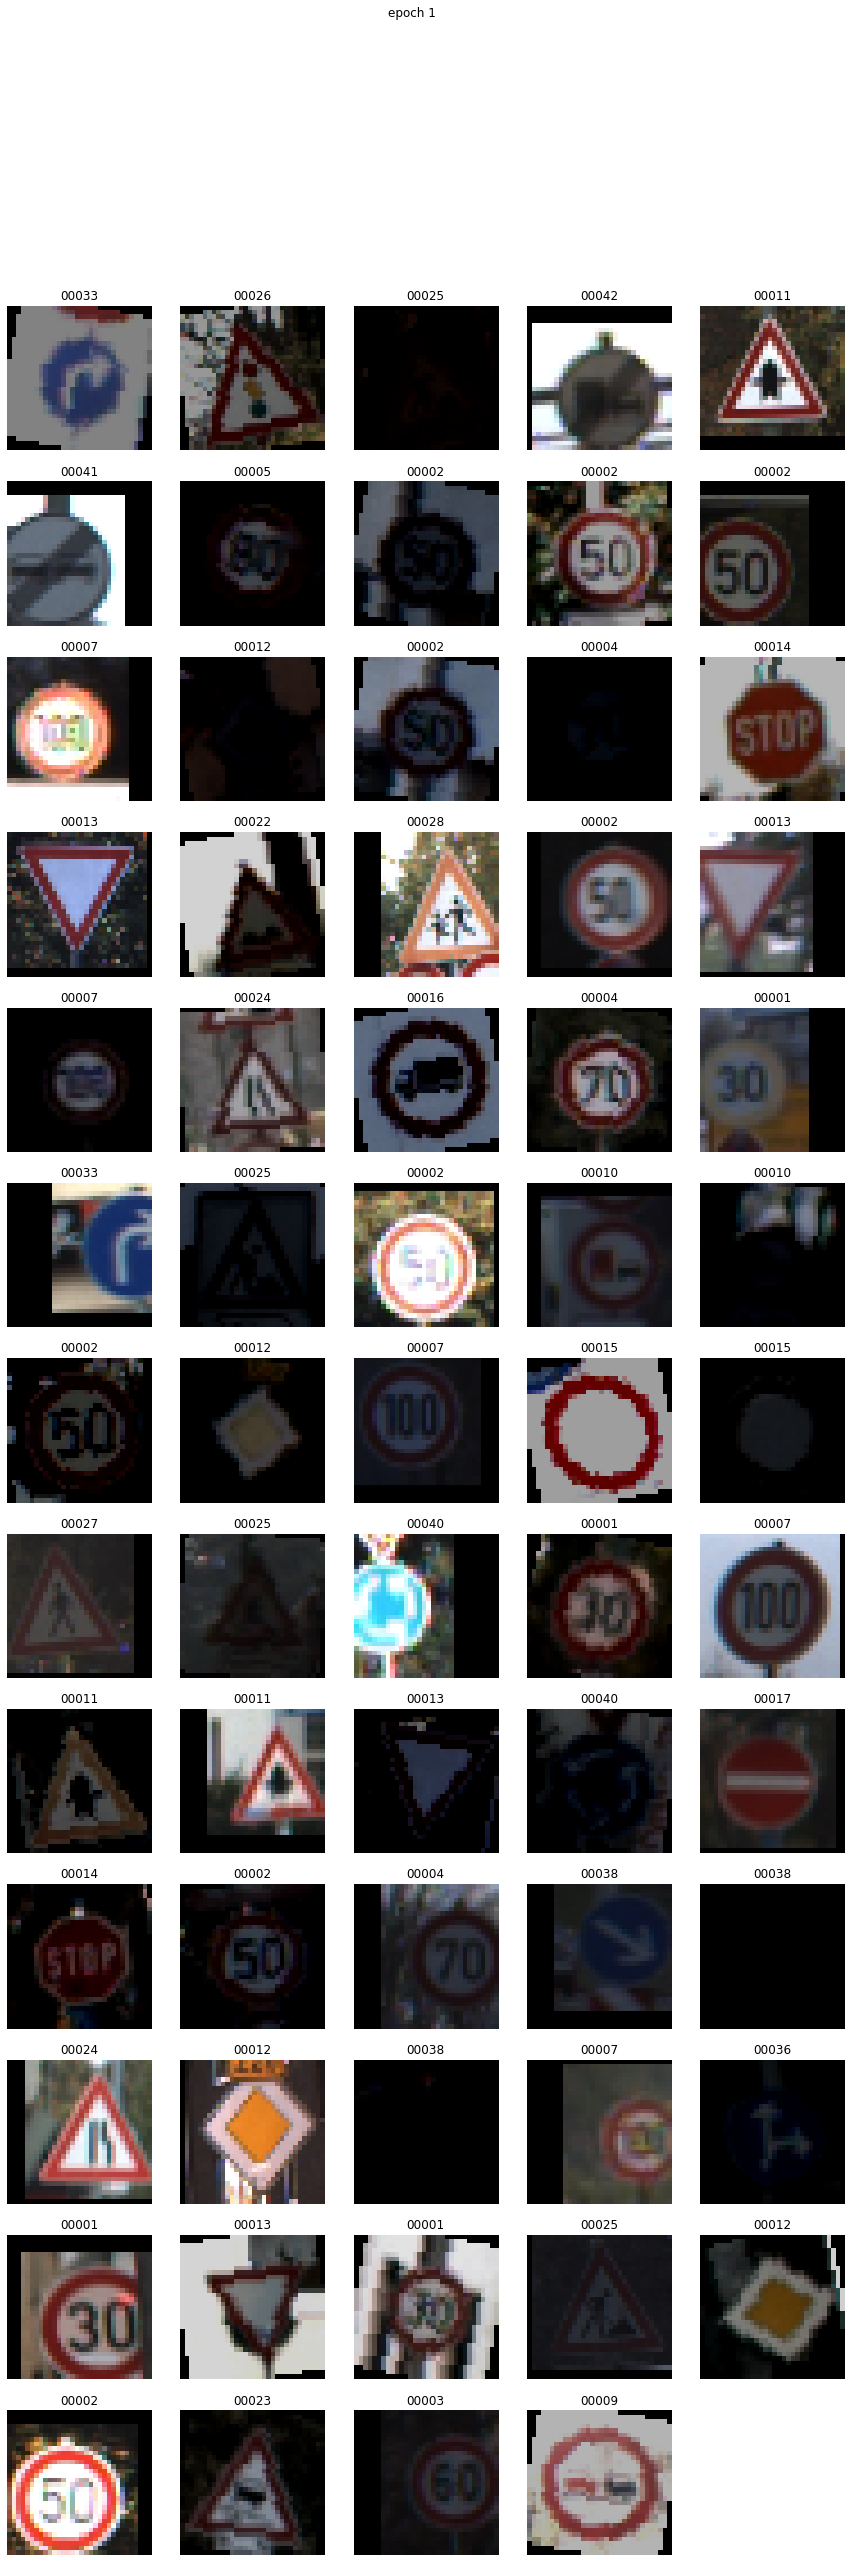

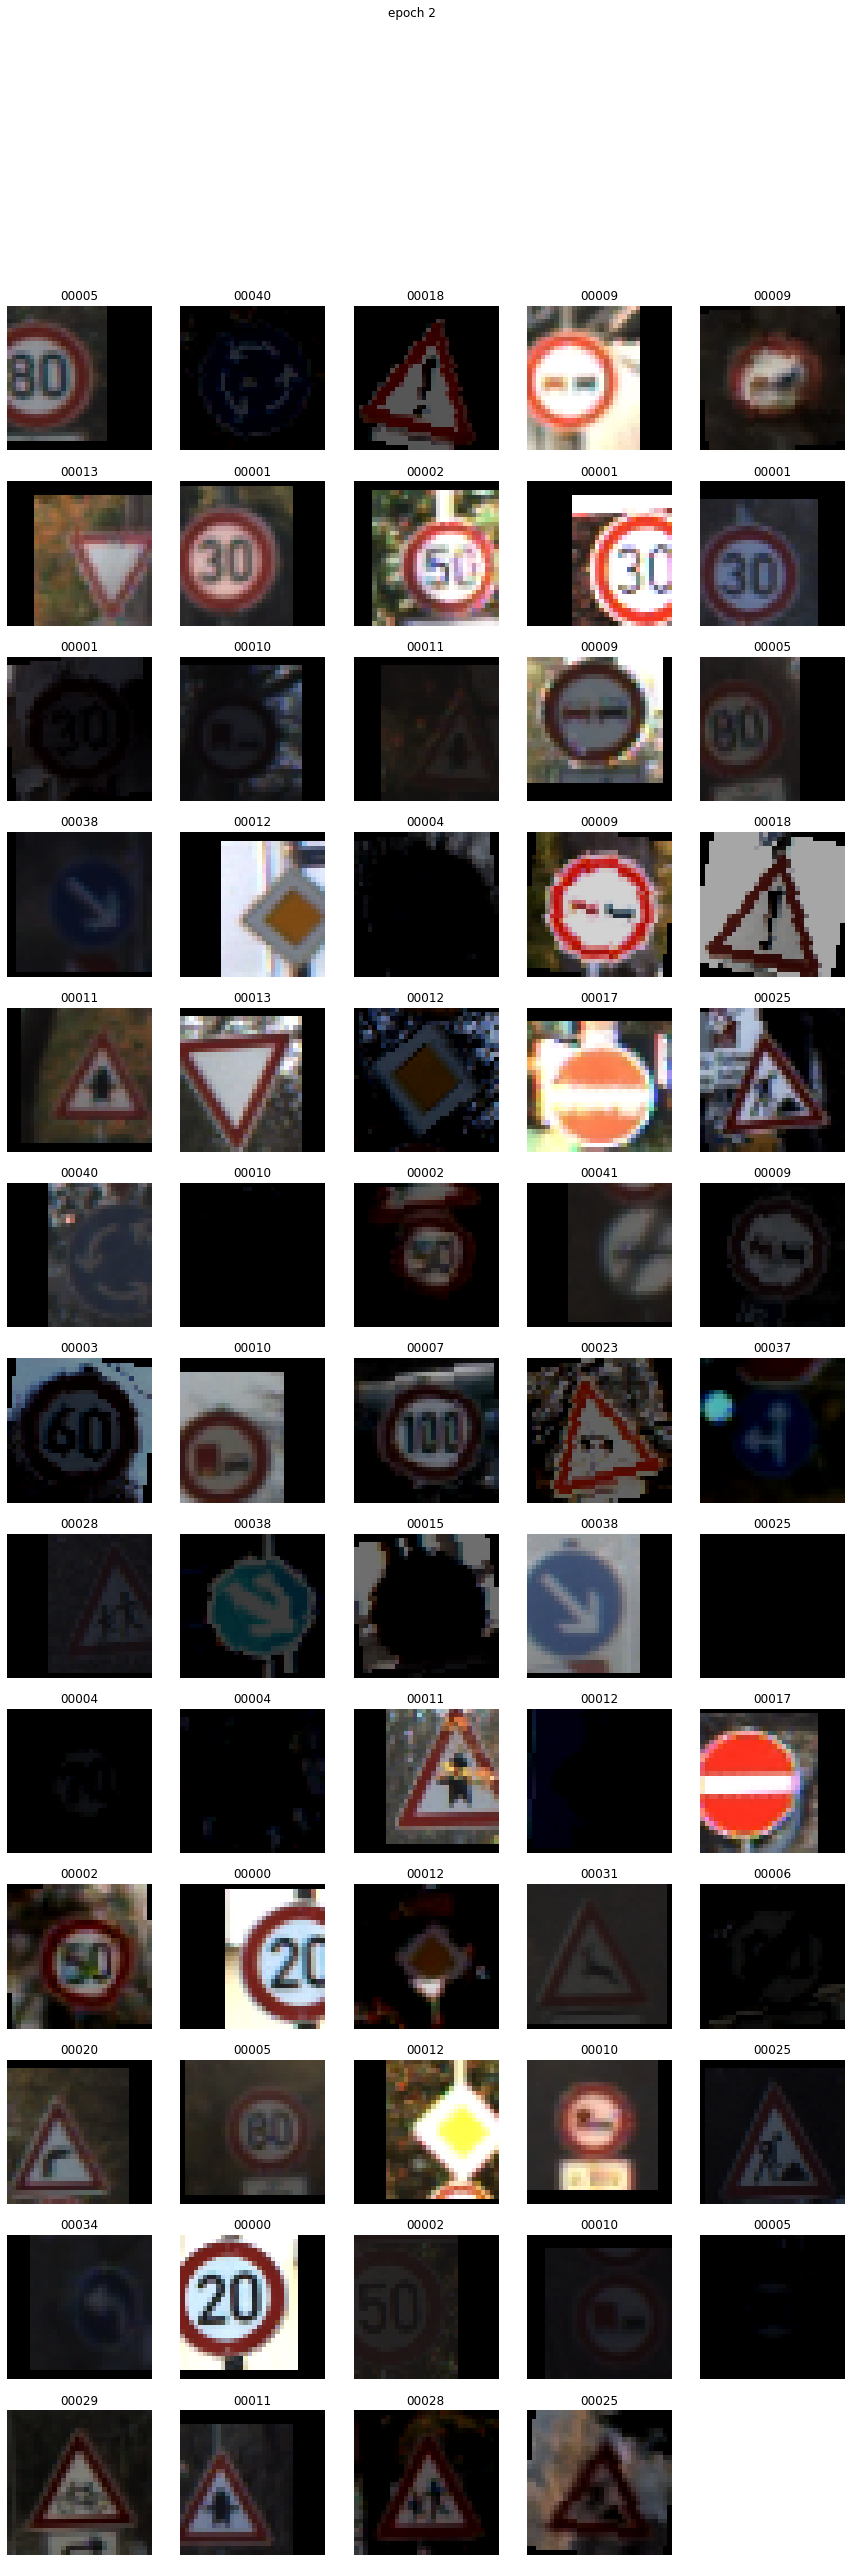

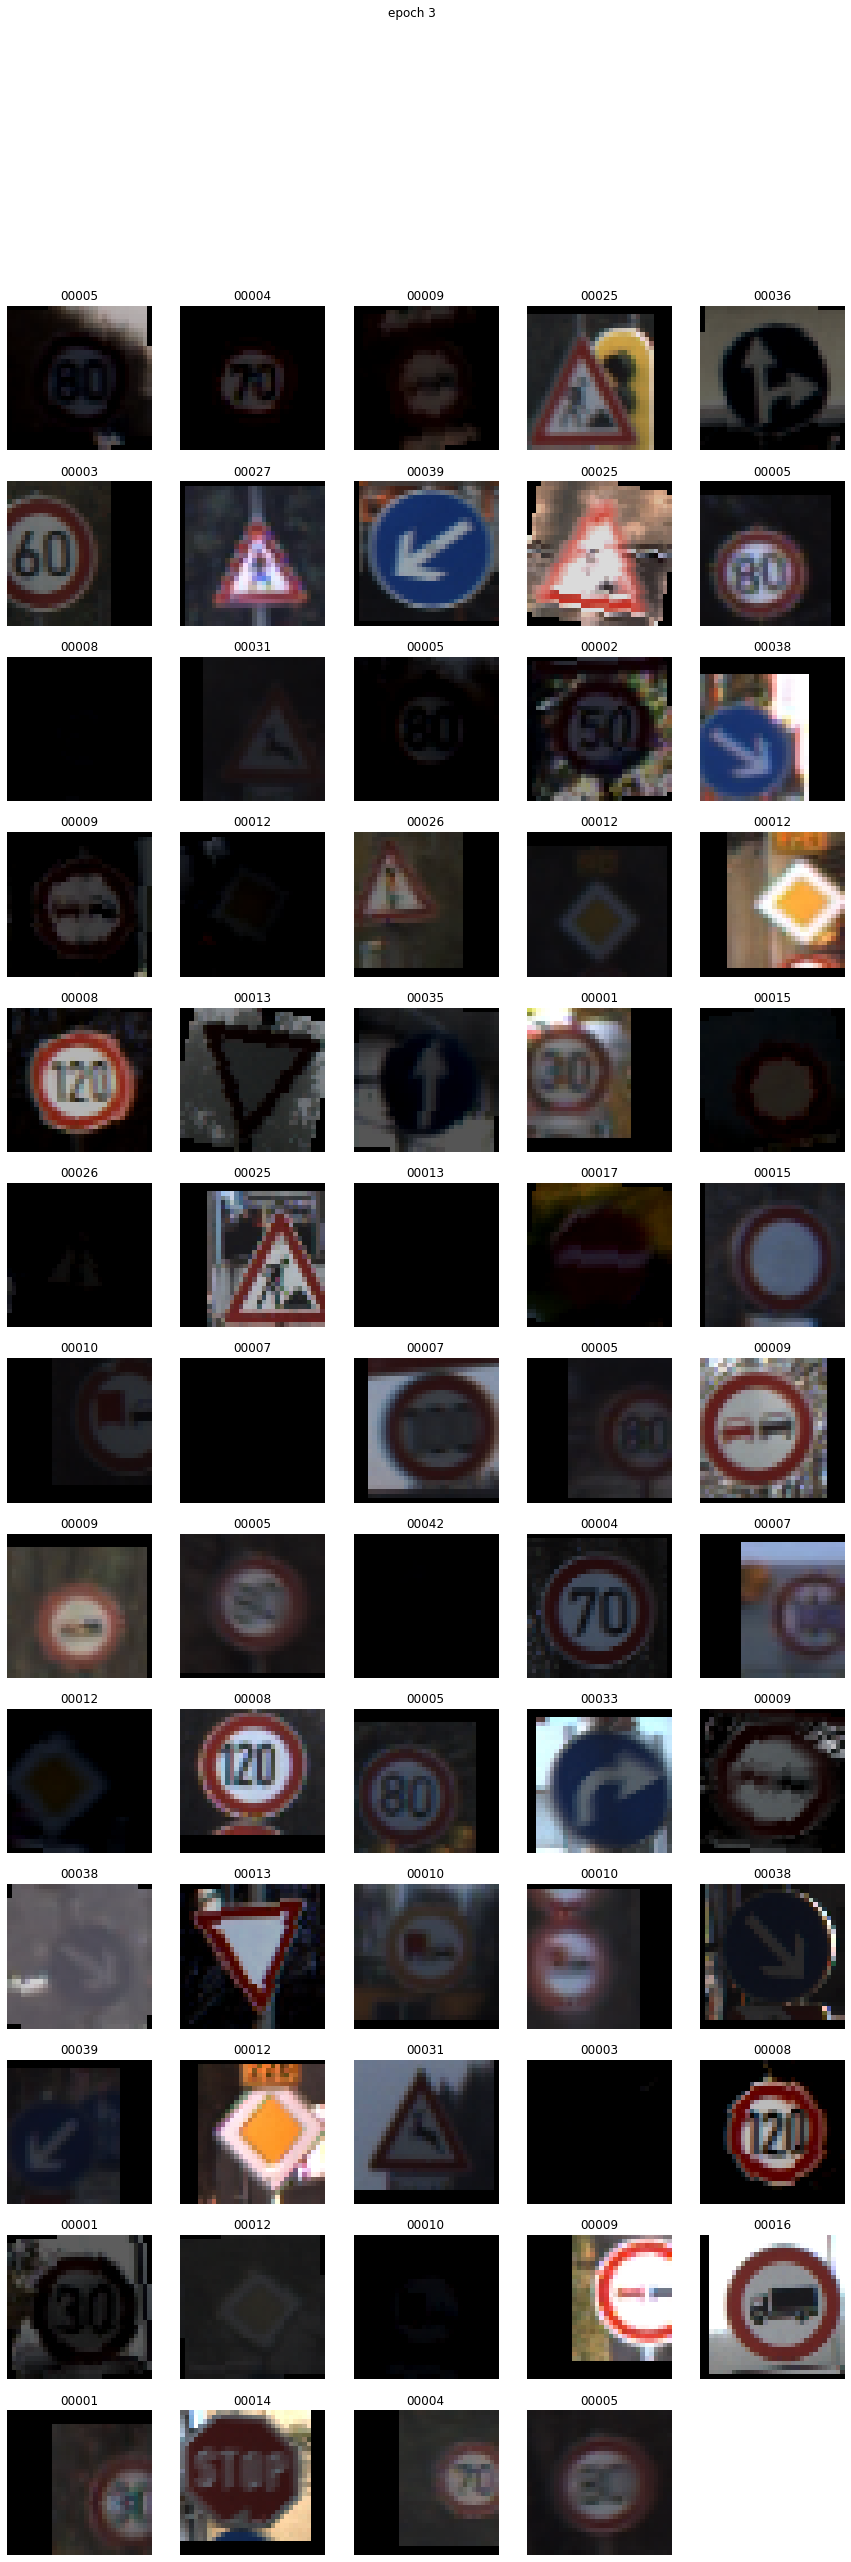

In [51]:
image_batch, label_batch = next(iter(train_dataset))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

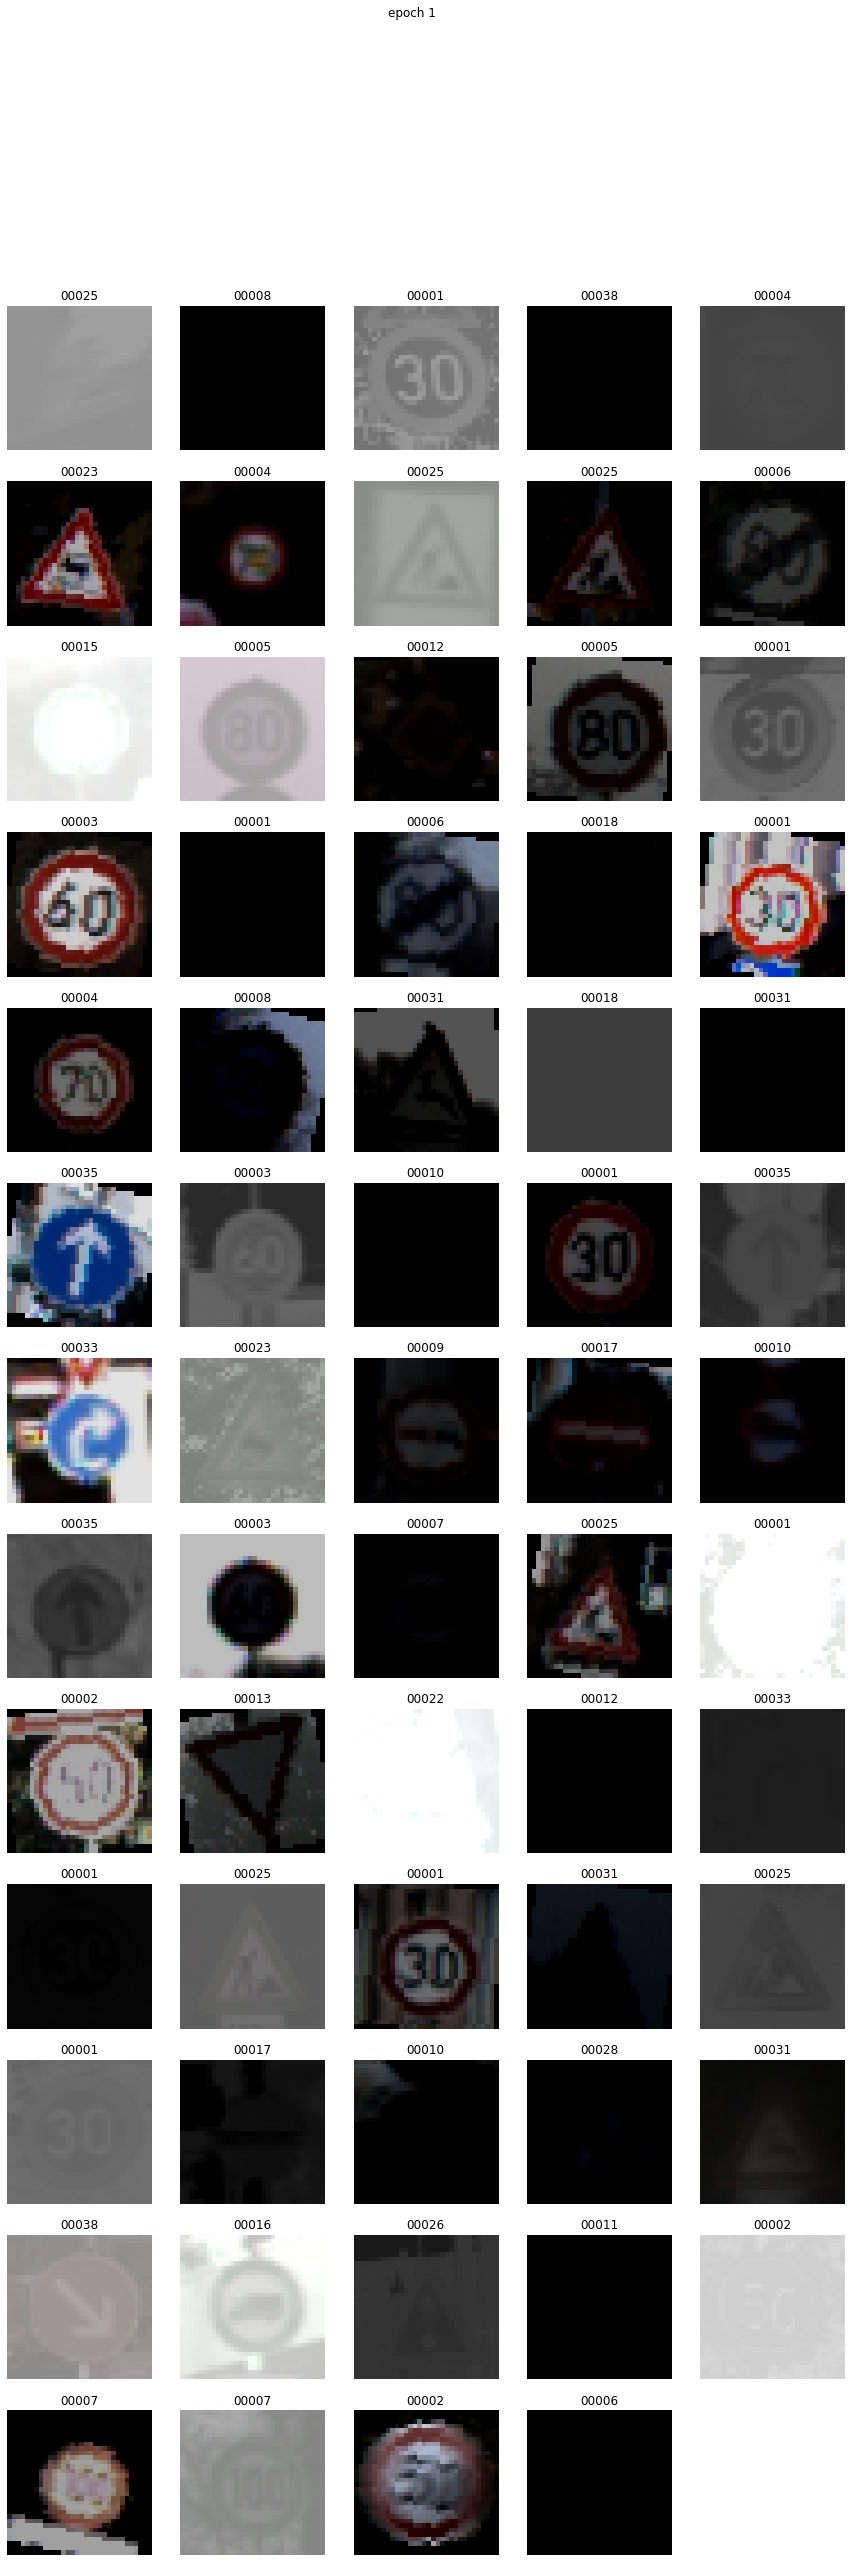

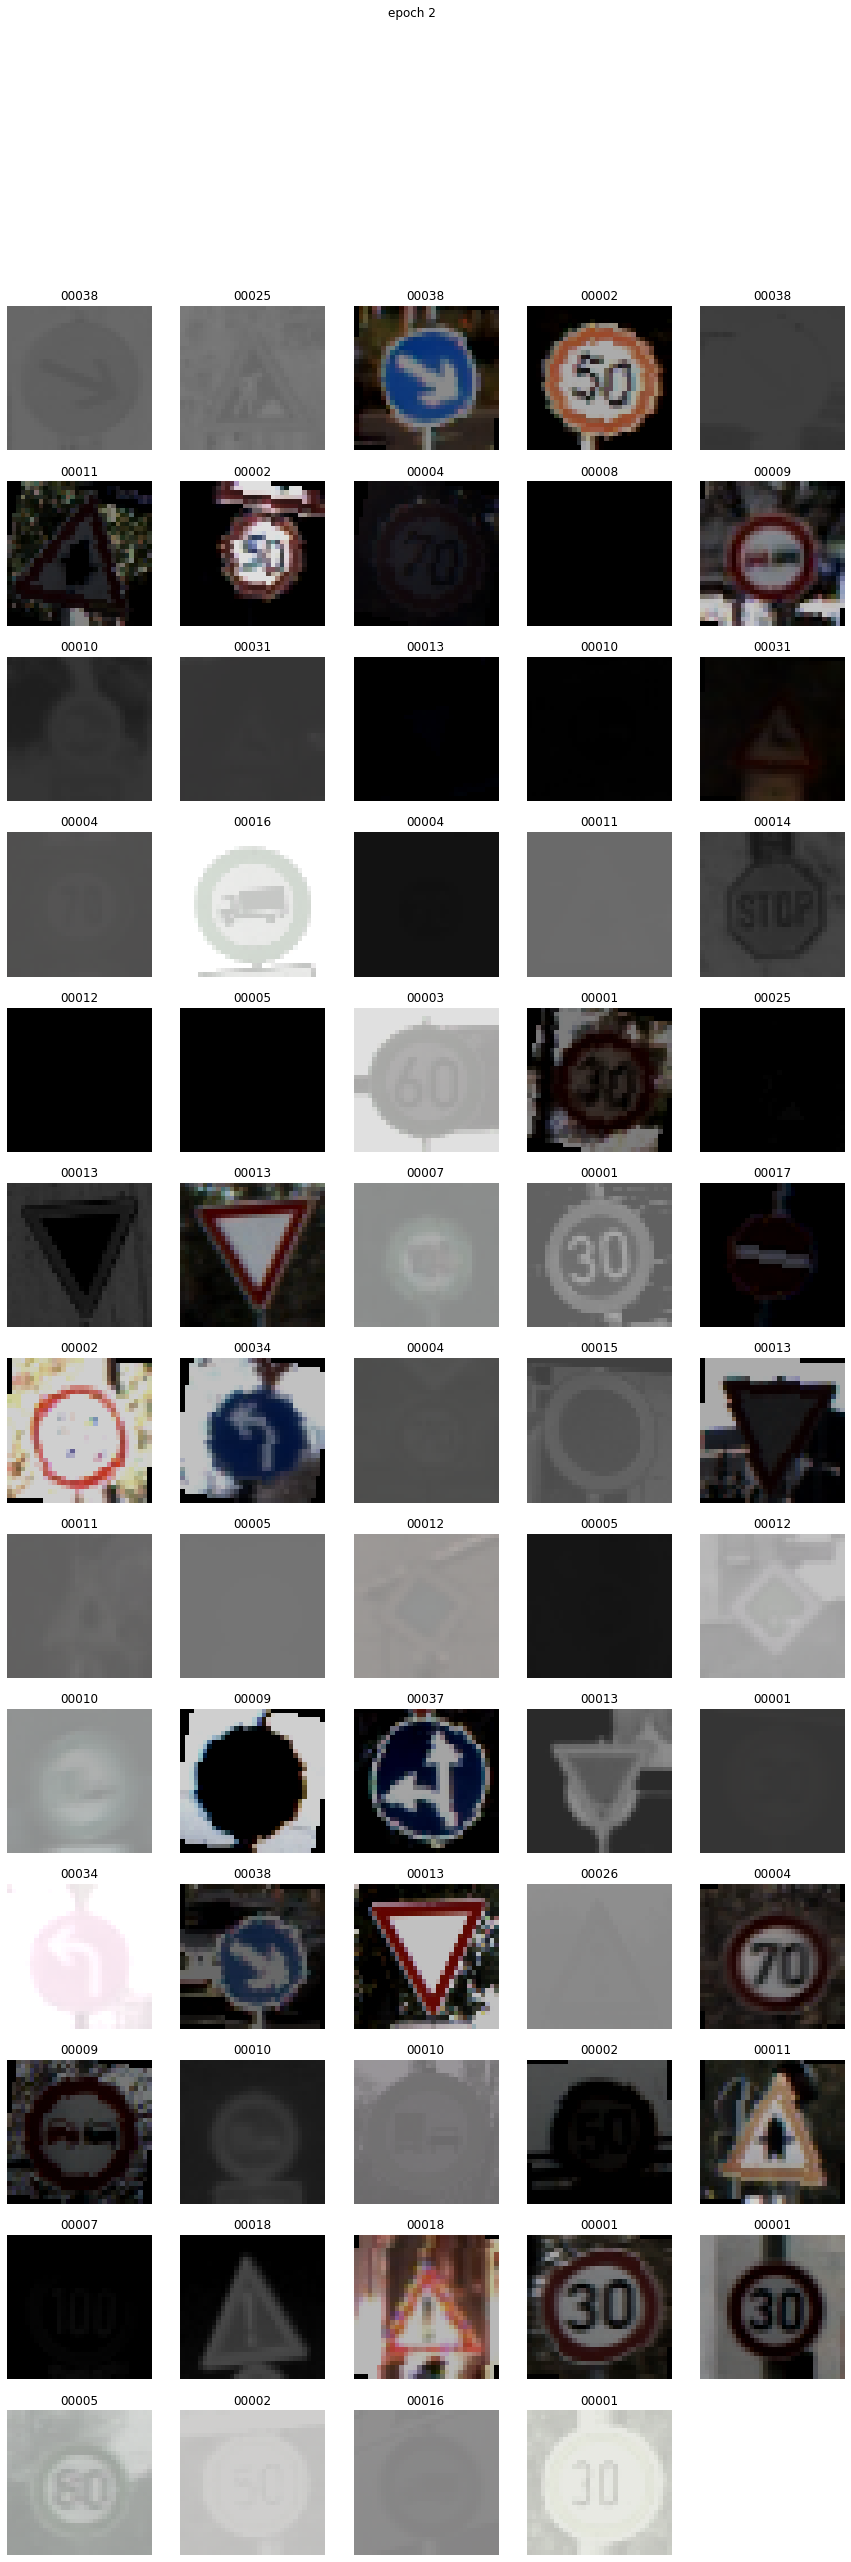

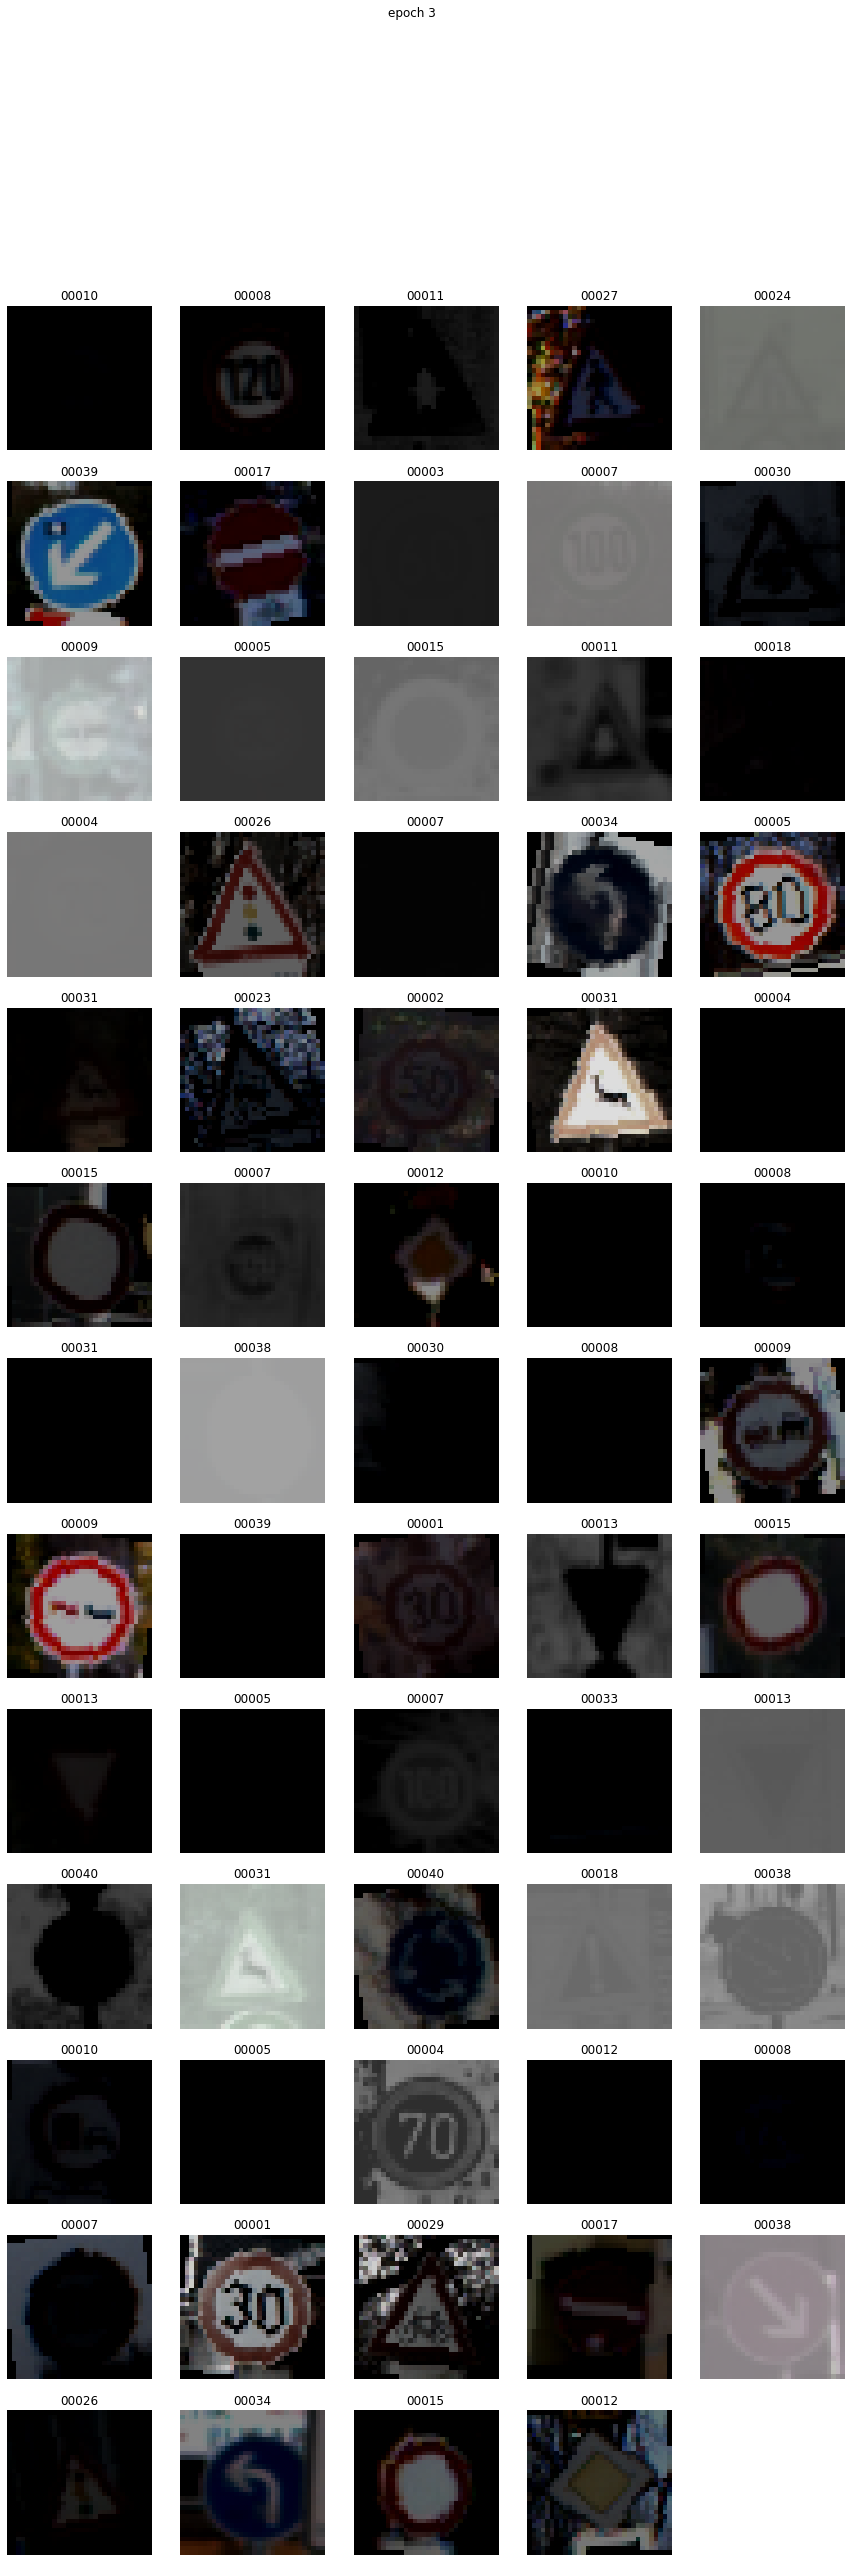

In [52]:
image_batch, label_batch = next(iter(train_datasetB))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(train_datasetB))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(train_datasetB))      
show_batch(image_batch, label_batch.numpy(), 3)


In [54]:
train_size = int(0.8*train_dataset_length)
val_size = int(0.2*train_dataset_length)

In [55]:
train_sizeB = int(0.8*train_dataset_lengthB)
val_sizeB = int(0.2*train_dataset_lengthB)

In [56]:
train_Data = train_dataset.take(train_size)
val_Data = train_dataset.skip(train_size)
print(tf.data.experimental.cardinality(train_Data).numpy())

62734


In [57]:
train_DataB = train_datasetB.take(train_sizeB)
val_DataB = train_datasetB.skip(train_sizeB)
print(tf.data.experimental.cardinality(train_DataB).numpy())

62734


### Teste da Preparação de Data

In [58]:
data_dir = pathlib.Path(pathTest)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [59]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [61]:
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
test_Data_lengthB = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)
print("Total images in dataset B: ", test_Data_lengthB)  

Total images in dataset:  12630
Total images in dataset B:  12630


In [62]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

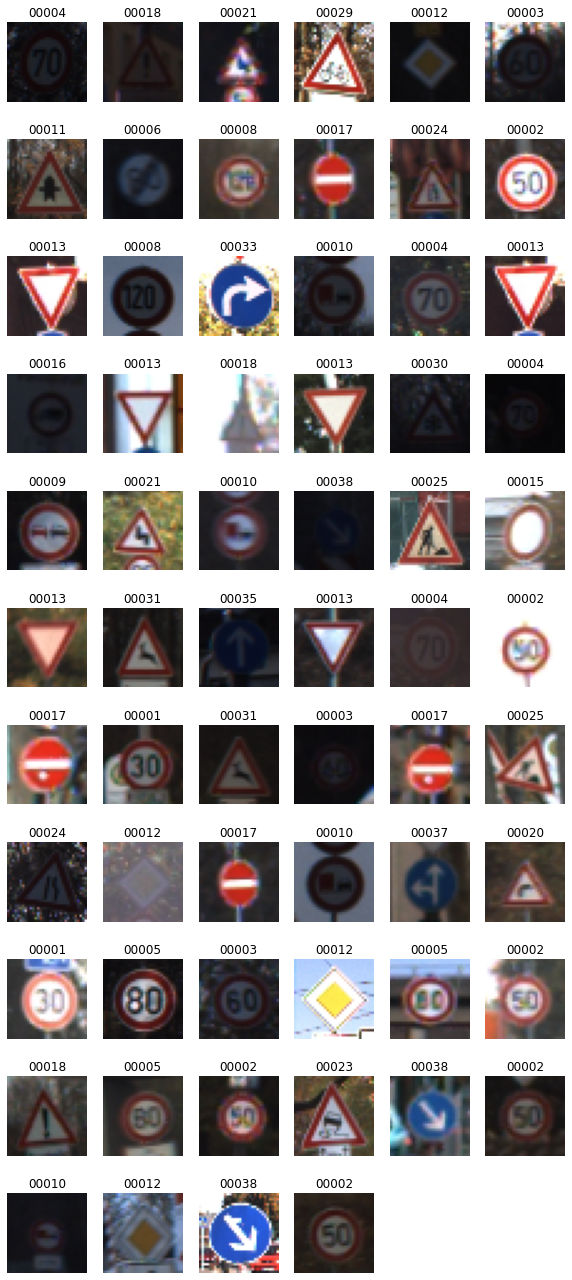

In [63]:
image_batch, label_batch = next(iter(test_Data))        
show_batchSimple(image_batch, label_batch.numpy())

In [64]:
model = Sequential()

model.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
model.add(LeakyReLU(alpha=0.01))  
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(196, (5, 5) )) 
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(256, (5, 5) ) )   
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Flatten())
model.add(LeakyReLU(alpha=0.0)) 
model.add(Dense(384))
model.add(LeakyReLU(alpha=0.0))             
model.add(Dropout(0.5)) 

model.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])

In [65]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 196)       0         
                                                        

In [66]:
file_path = './TrainModels/static_Augmentation.ckpt'

callbacks = prepare_callbacks(file_path)

history = model.fit(train_Data, steps_per_epoch = train_size/BATCH_SIZE,
          epochs=30, 
          validation_data=val_Data,
          validation_steps=val_size/BATCH_SIZE, 
          callbacks = callbacks)

Epoch 1/30
  2/980 [..............................] - ETA: 29:20 - loss: 4.9595 - accuracy: 0.0312

KeyboardInterrupt: 

In [68]:
file_path = './TrainModels/static_Augmentation.ckpt'

callbacks = prepare_callbacks(file_path)

historyB = model.fit(train_DataB, steps_per_epoch = train_size/BATCH_SIZE,
          epochs=30, 
          validation_data=val_DataB,
          validation_steps=val_sizeB/BATCH_SIZE, 
          callbacks = callbacks)

Epoch 1/30


KeyboardInterrupt: 

### Load Modelo treinado

In [ ]:
#model.load_weights(file_path)

#evalV1 = model.evaluate(test_Data, verbose=2)
#valV1 = model.evaluate(val_Data, steps=1, batch_size=0.2 * train_Data_length, verbose=2)

In [ ]:
show_history(history)

In [ ]:
show_history(historyB)

In [ ]:
model_eval = model.evaluate(test_Data, verbose=2)
print(model_eval)

model_val = model.evaluate(val_Data, steps=1, batch_size=val_size, verbose=2)
print(model_val)

In [ ]:
model_evalB = model.evaluate(test_DataB, verbose=2)
print(model_evalB)

model_valB = model.evaluate(val_DataB, steps=1, batch_size=val_size, verbose=2)
print(model_valB)

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in test_Data.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(model.predict(images.numpy()))


In [ ]:
show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9861 )/3 + 1))

In [ ]:
numpy_labelsB = []
numpy_imagesB = []
predB = []

for images, labels in test_DataB.take(-1):  # take all batches of dataset
    numpy_imagesB.extend(images.numpy())
    numpy_labelsB.extend(labels.numpy())
    predB.extend(model.predict(images.numpy()))


In [ ]:
show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9861 )/3 + 1))